# Predicting Prices in Ride-hailing Services

# Define your Project Expected Outcomes

##### Accurate Price Predictions:

The primary expected outcome is to build a predictive model that can accurately estimate ride-hailing prices. The model should minimize prediction errors and enable ride hailing companies provide fare estimates that are accurate and inline with the actual prices.  
This will provide a competitive advantage to the company in the ride-hailing market as being able to offer competitive and transparent pricing can attract and retain customers.
It would also result in an improved customer experience and satisfaction as accurate predictions reduce the likelihood of surprise price changes.
   

##### Data-Driven Insights:

The project will also strive to understand and gain valuable insights into how various factors (e.g., time of day, distance, weather, surge multiplier) impact cab fares. These insights can inform business decisions and marketing strategies.




# Data Description

There are two data files in the dataset:

- cab_rides.csv: Consists of the details of each ride along with its corresponding price.

- weather.csv: Consists of the components of weather conditions at a particular instant of time.

In [949]:
#Import neccessary packages for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,auc,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import median_absolute_error

In [950]:
#Read in the Rides data
rides = pd.read_csv("cab_rides.csv")

In [951]:
#View few rows
rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


Data Dictionary:
    
- distance: distance between source and destination
- cab_type: Uber or Lyft
- time_stamp: epoch time when data was queried
- destination: destination of the ride
- source: the starting point of the ride
- price: price estimate for the ride in USD
- surge_multiplier: surge_multiplier: The surge multiplier applied to the price during peak hours or high demand, default is 1
- id: unique identifier
- product_id: uber/lyft identifier for cab-type
- name: visible type of the cab: eg: Uber Pool, UberXL

In [952]:
#Read in the weather data
weather = pd.read_csv("weather.csv")
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


Data Dictionary
- temp: temperature in F
- location: The specific location associated with the weather data.
- clouds: The cloud coverage (ranging from 0.0 to 1.0, where 0.0 represents clear skies and 1.0 represents fully cloudy).
- pressure: pressure in mb
- rain: rain in inches for the last hr
- time_stamp: epoch time when row data was collected
- humidity: humidity in %
- wind: wind speed in mph

# Data Preprocessing

First, we will try basic steps which involve data cleaning like removing null values, changing the date_time to the desired format, andother data preprocessing steps.

In [953]:
#convert the timestamp into the desirable format
rides['date_time'] = pd.to_datetime(rides['time_stamp']/1000, unit='s')
weather['date_time'] = pd.to_datetime(weather['time_stamp'], unit='s')

- rides['time_stamp'] refers to the 'time_stamp' column in the 'rides' DataFrame.
- /1000 is used to convert the Unix timestamps from milliseconds to seconds, which is the unit expected by the to_datetime() function.
- unit='s' specifies that the input values are in seconds.

In [954]:
rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999872
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064


In [955]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date_time
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01


CAUTION: The cab data was queried every 5 mins and weather data every 1 hr. So there is a mismatch in the time, therefore data should be systematically join using the on the basis of date ALONE.

In [956]:
#make a coloumn of merge date containing date merged with the location 
#so that we can join the two dataframes on the basis of 'merge_date'
rides['merge_date'] = rides.source.astype(str) +" - "+ rides.date_time.dt.date.astype("str") +" - "+ rides.date_time.dt.hour.astype("str")
weather['merge_date'] = weather.location.astype(str) +" - "+ weather.date_time.dt.date.astype("str") +" - "+ weather.date_time.dt.hour.astype("str")

In [957]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date_time,merge_date
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01,Back Bay - 2018-12-16 - 23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01,Beacon Hill - 2018-12-16 - 23
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01,Boston University - 2018-12-16 - 23
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01,Fenway - 2018-12-16 - 23
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01,Financial District - 2018-12-16 - 23


In [958]:
# change the index to merge_date column so joining the two datasets will not generate any error.
weather.index = weather['merge_date']
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date_time,merge_date
merge_date,,,,,,,,,,
Back Bay - 2018-12-16 - 23,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01,Back Bay - 2018-12-16 - 23
Beacon Hill - 2018-12-16 - 23,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01,Beacon Hill - 2018-12-16 - 23
Boston University - 2018-12-16 - 23,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01,Boston University - 2018-12-16 - 23
Fenway - 2018-12-16 - 23,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01,Fenway - 2018-12-16 - 23
Financial District - 2018-12-16 - 23,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01,Financial District - 2018-12-16 - 23


In [959]:
final_dataframe = rides.join(weather,on=['merge_date'],rsuffix ='_w')
#drop the null values rows
final_dataframe=final_dataframe.dropna(axis=0)

In [960]:
final_dataframe.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w,merge_date_w
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,44.31,Haymarket Square,1.00,1003.17,0.1123,1.543285e+09,0.90,13.69,2018-11-27 02:15:20,Haymarket Square - 2018-11-27 - 2
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,43.82,Haymarket Square,0.99,1002.59,0.0997,1.543287e+09,0.89,11.57,2018-11-27 02:45:20,Haymarket Square - 2018-11-27 - 2
9,1.08,Lyft,1543315522249,Northeastern University,Back Bay,27.5,1.0,8612d909-98b8-4454-a093-30bd48de0cb3,lyft_luxsuv,Lux Black XL,2018-11-27 10:45:22.249000192,Back Bay - 2018-11-27 - 10,44.56,Back Bay,0.99,990.78,0.0213,1.543314e+09,0.96,5.87,2018-11-27 10:15:20,Back Bay - 2018-11-27 - 10
9,1.08,Lyft,1543315522249,Northeastern University,Back Bay,27.5,1.0,8612d909-98b8-4454-a093-30bd48de0cb3,lyft_luxsuv,Lux Black XL,2018-11-27 10:45:22.249000192,Back Bay - 2018-11-27 - 10,44.95,Back Bay,0.99,990.87,0.0087,1.543316e+09,0.97,6.14,2018-11-27 10:45:20,Back Bay - 2018-11-27 - 10
15,1.11,Uber,1545004511430,West End,North End,7.5,1.0,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-12-16 23:55:11.430000128,North End - 2018-12-16 - 23,42.36,North End,1.00,1012.15,0.2088,1.545004e+09,0.77,11.46,2018-12-16 23:45:01,North End - 2018-12-16 - 23


In [961]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190311 entries, 1 to 693058
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          190311 non-null  float64       
 1   cab_type          190311 non-null  object        
 2   time_stamp        190311 non-null  int64         
 3   destination       190311 non-null  object        
 4   source            190311 non-null  object        
 5   price             190311 non-null  float64       
 6   surge_multiplier  190311 non-null  float64       
 7   id                190311 non-null  object        
 8   product_id        190311 non-null  object        
 9   name              190311 non-null  object        
 10  date_time         190311 non-null  datetime64[ns]
 11  merge_date        190311 non-null  object        
 12  temp              190311 non-null  float64       
 13  location          190311 non-null  object        
 14  clou

In [962]:
#make different columns of day and hour to simplify the format of date 
final_dataframe['day'] = final_dataframe.date_time.dt.dayofweek
final_dataframe['hour'] = final_dataframe.date_time.dt.hour

In [963]:
final_dataframe.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w,merge_date_w,day,hour
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,44.31,Haymarket Square,1.00,1003.17,0.1123,1.543285e+09,0.90,13.69,2018-11-27 02:15:20,Haymarket Square - 2018-11-27 - 2,1,2
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,43.82,Haymarket Square,0.99,1002.59,0.0997,1.543287e+09,0.89,11.57,2018-11-27 02:45:20,Haymarket Square - 2018-11-27 - 2,1,2
9,1.08,Lyft,1543315522249,Northeastern University,Back Bay,27.5,1.0,8612d909-98b8-4454-a093-30bd48de0cb3,lyft_luxsuv,Lux Black XL,2018-11-27 10:45:22.249000192,Back Bay - 2018-11-27 - 10,44.56,Back Bay,0.99,990.78,0.0213,1.543314e+09,0.96,5.87,2018-11-27 10:15:20,Back Bay - 2018-11-27 - 10,1,10
9,1.08,Lyft,1543315522249,Northeastern University,Back Bay,27.5,1.0,8612d909-98b8-4454-a093-30bd48de0cb3,lyft_luxsuv,Lux Black XL,2018-11-27 10:45:22.249000192,Back Bay - 2018-11-27 - 10,44.95,Back Bay,0.99,990.87,0.0087,1.543316e+09,0.97,6.14,2018-11-27 10:45:20,Back Bay - 2018-11-27 - 10,1,10
15,1.11,Uber,1545004511430,West End,North End,7.5,1.0,50ef1165-9d23-416c-a65c-18906207b295,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-12-16 23:55:11.430000128,North End - 2018-12-16 - 23,42.36,North End,1.00,1012.15,0.2088,1.545004e+09,0.77,11.46,2018-12-16 23:45:01,North End - 2018-12-16 - 23,6,23


# Now go ahead with further data processing steps you need to do.

In [964]:
final_dataframe.duplicated().sum() #checking dataset for duplicates

0

In [965]:
#drop columns not needed

final_dataframe.drop(['id', 'time_stamp', 'time_stamp_w', 'product_id','date_time','merge_date', 'date_time_w', 'merge_date_w', 'location'], axis=1, inplace=True)

In [966]:
final_dataframe.head(30)

,distance,cab_type,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day,hour
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,44.31,1.00,1003.17,0.1123,0.90,13.69,1,2
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,43.82,0.99,1002.59,0.0997,0.89,11.57,1,2
9,1.08,Lyft,Northeastern University,Back Bay,27.5,1.0,Lux Black XL,44.56,0.99,990.78,0.0213,0.96,5.87,1,10
9,1.08,Lyft,Northeastern University,Back Bay,27.5,1.0,Lux Black XL,44.95,0.99,990.87,0.0087,0.97,6.14,1,10
15,1.11,Uber,West End,North End,7.5,1.0,WAV,42.36,1.00,1012.15,0.2088,0.77,11.46,6,23
23,0.72,Lyft,Haymarket Square,North Station,26.0,1.0,Lux Black XL,42.35,0.91,1018.92,0.0100,0.73,9.44,6,16
32,3.24,Lyft,Northeastern University,North Station,3.5,1.0,Shared,44.18,0.99,1001.50,0.2420,0.89,12.40,1,3
32,3.24,Lyft,Northeastern University,North Station,3.5,1.0,Shared,44.25,1.00,1000.81,0.1617,0.90,13.70,1,3
33,3.24,Lyft,Northeastern University,North Station,11.0,1.0,Lyft,48.34,0.99,1006.02,0.0030,0.94,4.11,6,18
35,3.24,Lyft,Northeastern University,North Station,26.0,1.0,Lux Black,38.54,1.00,1019.06,0.0051,0.91,3.03,6,9


### Descriptive Analysis/Visualization

In [967]:
final_dataframe['distance'].mean()

2.1816567092805728

In [968]:
final_dataframe['distance'].max()

7.5

In [969]:
final_dataframe['distance'].min()

0.02

c:\Users\adaog\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<function matplotlib.pyplot.show(close=None, block=None)>

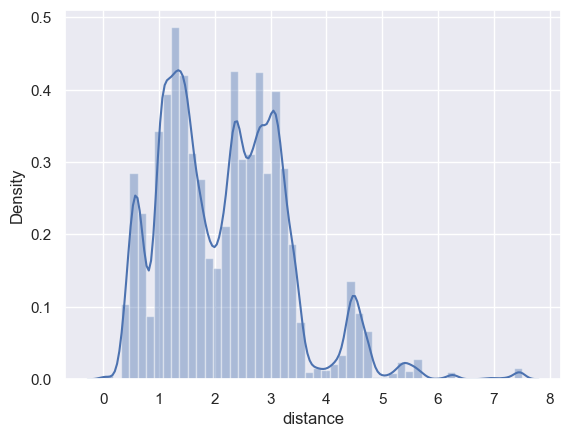

In [970]:
sns.distplot(final_dataframe['distance'])
plt.show

In [971]:
def drop_outlier(df,col):
    q1,q3 =np.percentile(df[col],[25,75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr #Anythig higher than the lower is an outlier
    upper = q3 + 1.5*iqr #Anythig higher than the upper is an outlier

    df = df[df[col]< upper]
    df = df[df[col]> lower]

    df.reset_index(drop = True,inplace=True)

    return df

In [972]:
final_dataframe = drop_outlier(final_dataframe, 'distance')

c:\Users\adaog\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<function matplotlib.pyplot.show(close=None, block=None)>

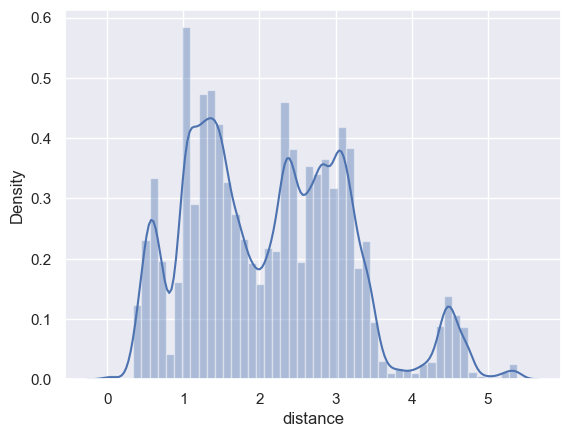

In [973]:
sns.distplot(final_dataframe['distance'])
plt.show

In [974]:
final_dataframe['distance'].mean()

2.1362423672331716

In [975]:
# Group the data by 'Hour' and calculate the mean of 'Surge Multiplier' for each hour
hourly_average = final_dataframe.groupby('hour')['surge_multiplier'].mean().reset_index()

print(hourly_average)



    hour  surge_multiplier
0      0          1.011580
1      1          1.013992
2      2          1.013375
3      3          1.016388
4      4          1.010849
5      5          1.013922
6      6          1.012608
7      7          1.016735
8      8          1.015348
9      9          1.017734
10    10          1.018281
11    11          1.013033
12    12          1.012809
13    13          1.018747
14    14          1.012819
15    15          1.017434
16    16          1.009785
17    17          1.013774
18    18          1.017937
19    19          1.019504
20    20          1.023093
21    21          1.014450
22    22          1.010096
23    23          1.012957


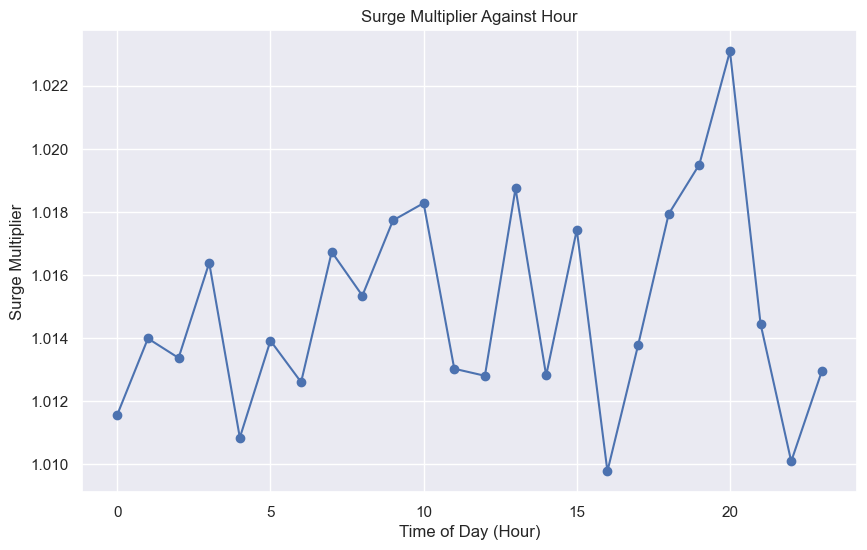

In [976]:

# Create a line plot for mean time of day vs. surge multiplier
plt.figure(figsize=(10, 6))
plt.plot(hourly_average['hour'], hourly_average['surge_multiplier'], marker='o', linestyle='-')
plt.title('Surge Multiplier Against Hour')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Surge Multiplier')
plt.grid(True)
plt.show()


# graph shows us time of day where surge is at the highest and lowest

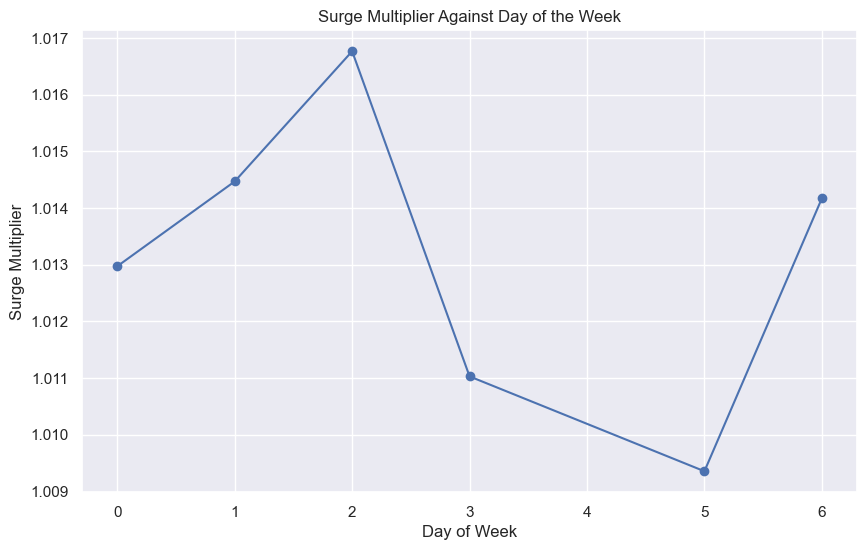

In [977]:
# Calculating average day of the week against surge multiplier
day_average = final_dataframe.groupby('day')['surge_multiplier'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(day_average['day'], day_average['surge_multiplier'], marker='o', linestyle='-')
plt.title('Surge Multiplier Against Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Surge Multiplier')
plt.grid(True)
plt.show()

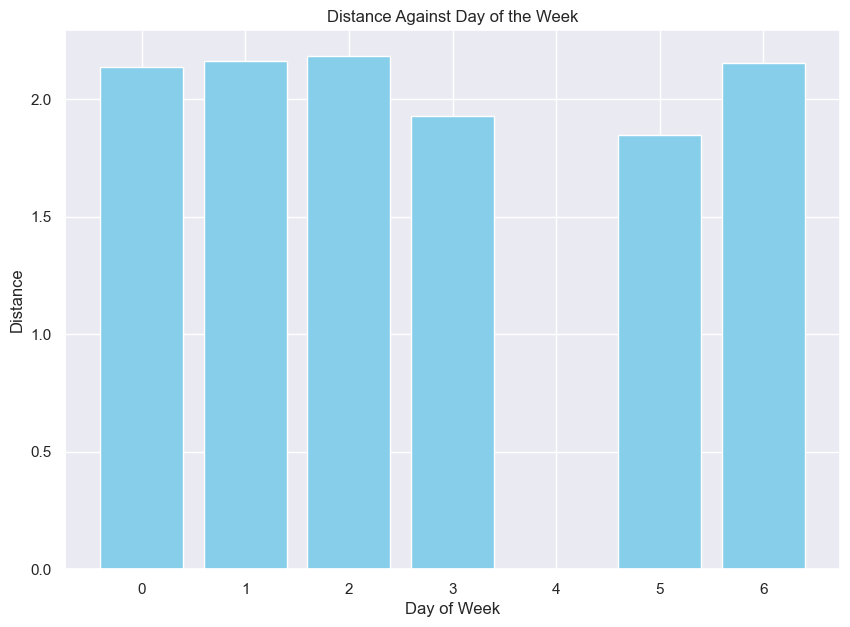

In [978]:
# Calculating average day of the week against distance
day_average = final_dataframe.groupby('day')['distance'].mean().reset_index()
plt.figure(figsize=(10, 7))
plt.bar(day_average['day'], day_average['distance'], color='skyblue')
plt.title('Distance Against Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [979]:
day_average = final_dataframe.groupby('day')['price'].mean().reset_index()
day_average

,day,price
0,0,16.389452
1,1,16.498933
2,2,16.604090
3,3,15.714856
4,5,15.615113
5,6,16.396113


In [980]:
y = day_average['price']
x = day_average['day']

fig = px.bar(x=x, y=y, 
                      labels= {'x': 'Day', 'y': 'Avg Price'}, 
                      title = 'Average Price Distribution by Day of the week',
                      color_discrete_sequence=['skyblue'], text=round(y,2))
fig.update_layout(title = {'font':{'size':23}})
        
fig.update_layout(height = 500, width = 750)

fig.show()

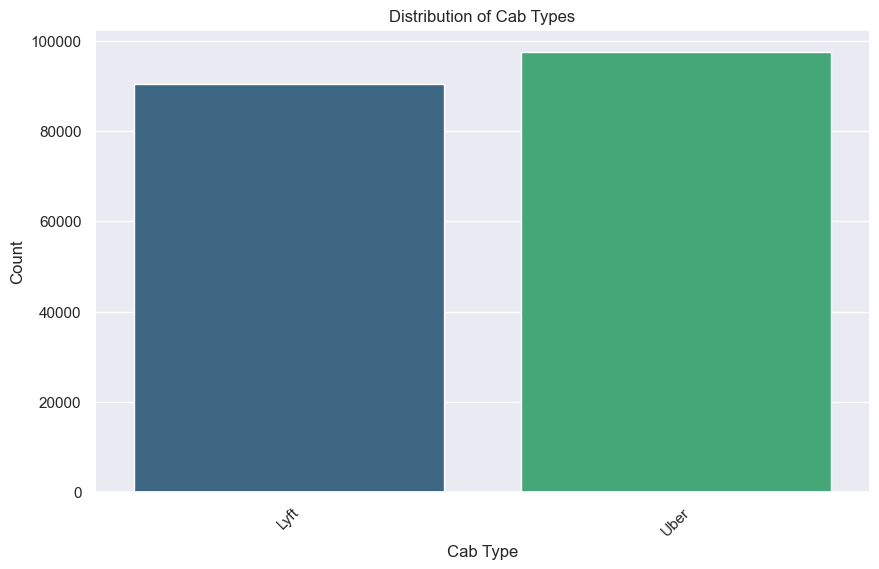

In [981]:
# bar chart for cab type distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=final_dataframe, x='cab_type', palette='viridis')
plt.title('Distribution of Cab Types')
plt.xlabel('Cab Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

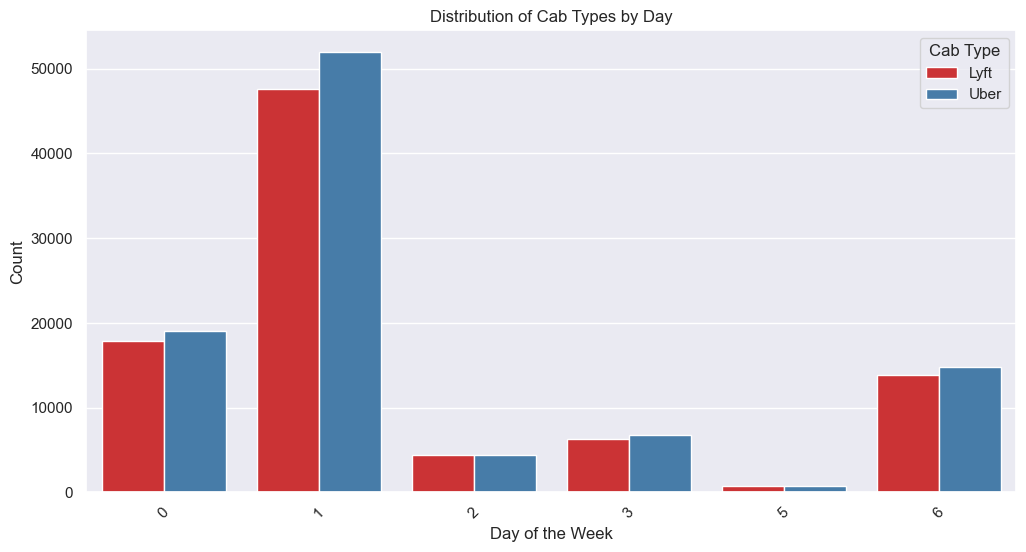

In [982]:
# Create a stacked bar chart for day vs. cab type
plt.figure(figsize=(12, 6))
sns.countplot(data=final_dataframe, x='day', hue='cab_type', palette='Set1')
plt.title('Distribution of Cab Types by Day')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend(title='Cab Type', loc='upper right')
plt.xticks(rotation=45)
plt.show()


# shows that uber is generally ordered more but with a very little margin difference

In [983]:
final_dataframe['day'].unique()

array([1, 6, 0, 2, 3, 5], dtype=int64)

### Split Data

In [984]:
train,test = train_test_split(final_dataframe, test_size = 0.2, random_state =123)

In [985]:
train.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day,hour
185674,1.89,Uber,Theatre District,Northeastern University,9.5,1.0,WAV,38.89,0.99,1018.25,0.0336,0.93,5.21,6,10
119524,4.48,Uber,Fenway,Financial District,20.5,1.0,UberXL,45.04,0.97,1005.89,0.2202,0.87,11.33,1,0
160115,2.12,Uber,South Station,North Station,10.0,1.0,UberPool,34.82,0.83,1001.66,0.0320,0.65,12.36,1,5
114005,1.51,Uber,Back Bay,Boston University,8.0,1.0,UberX,34.88,1.00,1003.96,0.0030,0.92,9.72,0,10
170980,2.84,Lyft,West End,Northeastern University,19.5,1.0,Lux,37.88,1.00,1020.05,0.0193,0.86,1.85,6,7


In [986]:
train.shape

(150535, 15)

In [987]:
test.shape

(37634, 15)

In [988]:
#A1

train.reset_index(drop=True, inplace=True)
train.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day,hour
0,1.89,Uber,Theatre District,Northeastern University,9.5,1.0,WAV,38.89,0.99,1018.25,0.0336,0.93,5.21,6,10
1,4.48,Uber,Fenway,Financial District,20.5,1.0,UberXL,45.04,0.97,1005.89,0.2202,0.87,11.33,1,0
2,2.12,Uber,South Station,North Station,10.0,1.0,UberPool,34.82,0.83,1001.66,0.0320,0.65,12.36,1,5
3,1.51,Uber,Back Bay,Boston University,8.0,1.0,UberX,34.88,1.00,1003.96,0.0030,0.92,9.72,0,10
4,2.84,Lyft,West End,Northeastern University,19.5,1.0,Lux,37.88,1.00,1020.05,0.0193,0.86,1.85,6,7


In [989]:
#A2
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder
encoder = OneHotEncoder(drop="first", dtype='int')

# Use the same encoders used for training data
enc_data = pd.DataFrame(encoder.fit_transform(np.array(train[['destination', 'source', 
                                                                        'name', 'cab_type']])).toarray(), 
                                                                        columns=encoder.get_feature_names_out(['destination', 'source', 'name', 'cab_type']))

# Concatenate the encoded features
train = pd.concat([train, enc_data], axis=1)

# Drop the original categorical columns
train.drop(['destination', 'source', 'name', 'cab_type'], axis=1, inplace=True)

train 

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,day,hour,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,cab_type_Uber
0,1.89,9.5,1.0,38.89,0.99,1018.25,0.0336,0.93,5.21,6,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4.48,20.5,1.0,45.04,0.97,1005.89,0.2202,0.87,11.33,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2.12,10.0,1.0,34.82,0.83,1001.66,0.0320,0.65,12.36,1,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1.51,8.0,1.0,34.88,1.00,1003.96,0.0030,0.92,9.72,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,2.84,19.5,1.0,37.88,1.00,1020.05,0.0193,0.86,1.85,6,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150530,0.99,5.0,1.0,43.96,0.98,1005.99,0.1631,0.90,9.98,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
150531,1.54,9.0,1.0,44.16,0.99,1005.41,0.3130,0.90,11.30,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
150532,1.73,7.0,1.0,42.98,0.90,1014.56,0.0030,0.91,3.79,0,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
150533,0.73,7.0,1.0,38.36,0.51,997.88,0.0020,0.70,10.37,3,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [990]:
train.head(2)

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,day,hour,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,cab_type_Uber
0,1.89,9.5,1.0,38.89,0.99,1018.25,0.0336,0.93,5.21,6,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,4.48,20.5,1.0,45.04,0.97,1005.89,0.2202,0.87,11.33,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


### Feature Engineering

In [991]:
## multiply distance by time of day to create a new feature that could better predict price based on peak and off peak periods

#A10

def timedist (df,dist_col,hour_col):
    new = []

    df['time_distance'] = df[dist_col] * df[hour_col]

    return df



In [992]:
#A11

timedist (train, 'distance', 'hour')

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,day,hour,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,cab_type_Uber,time_distance
0,1.89,9.5,1.0,38.89,0.99,1018.25,0.0336,0.93,5.21,6,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,18.90
1,4.48,20.5,1.0,45.04,0.97,1005.89,0.2202,0.87,11.33,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.00
2,2.12,10.0,1.0,34.82,0.83,1001.66,0.0320,0.65,12.36,1,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,10.60
3,1.51,8.0,1.0,34.88,1.00,1003.96,0.0030,0.92,9.72,0,10,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,15.10
4,2.84,19.5,1.0,37.88,1.00,1020.05,0.0193,0.86,1.85,6,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,19.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150530,0.99,5.0,1.0,43.96,0.98,1005.99,0.1631,0.90,9.98,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0.00
150531,1.54,9.0,1.0,44.16,0.99,1005.41,0.3130,0.90,11.30,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.54
150532,1.73,7.0,1.0,42.98,0.90,1014.56,0.0030,0.91,3.79,0,14,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,24.22
150533,0.73,7.0,1.0,38.36,0.51,997.88,0.0020,0.70,10.37,3,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.46


In [993]:
x_train = train.drop('price', axis =1)
y_train = train['price']

In [994]:
col = x_train.columns
col

Index(['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day', 'hour', 'destination_Beacon Hill', 'destination_Boston University', 'destination_Fenway', 'destination_Financial District', 'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 'destination_Northeastern University', 'destination_South Station', 'destination_Theatre District', 'destination_West End', 'source_Beacon Hill', 'source_Boston University', 'source_Fenway', 'source_Financial District', 'source_Haymarket Square', 'source_North End', 'source_North Station', 'source_Northeastern University', 'source_South Station', 'source_Theatre District', 'source_West End', 'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_UberPool', 'name_UberX', 'name_UberXL', 'name_WAV', 'cab_type_Uber', 'time_distance'], dtype='object')

In [995]:
#scaling the features

from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
x_train = Scaler.fit_transform(x_train)

x_train = pd.DataFrame(x_train,columns=col)
x_train.head()

,distance,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,day,hour,destination_Beacon Hill,destination_Boston University,destination_Fenway,destination_Financial District,destination_Haymarket Square,destination_North End,destination_North Station,destination_Northeastern University,destination_South Station,destination_Theatre District,destination_West End,source_Beacon Hill,source_Boston University,source_Fenway,source_Financial District,source_Haymarket Square,source_North End,source_North Station,source_Northeastern University,source_South Station,source_Theatre District,source_West End,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,cab_type_Uber,time_distance
0,0.348231,0.0,0.279463,0.988889,0.892336,0.042793,0.891304,0.225032,1.000000,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.152456
1,0.830540,0.0,0.638273,0.966667,0.516423,0.281871,0.760870,0.621920,0.166667,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000
2,0.391061,0.0,0.042007,0.811111,0.387774,0.040743,0.282609,0.688716,0.166667,0.217391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.085505
3,0.277467,0.0,0.045508,1.000000,0.457725,0.003587,0.869565,0.517510,0.000000,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.121804
4,0.525140,0.0,0.220537,1.000000,0.947080,0.024471,0.739130,0.007134,1.000000,0.304348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160361


In [996]:
conti_feat = ['distance', 'surge_multiplier', 'temp', 'clouds', 
'pressure', 'rain', 'humidity', 'wind', 'day', 'hour', 'time_distance']

<function matplotlib.pyplot.show(close=None, block=None)>

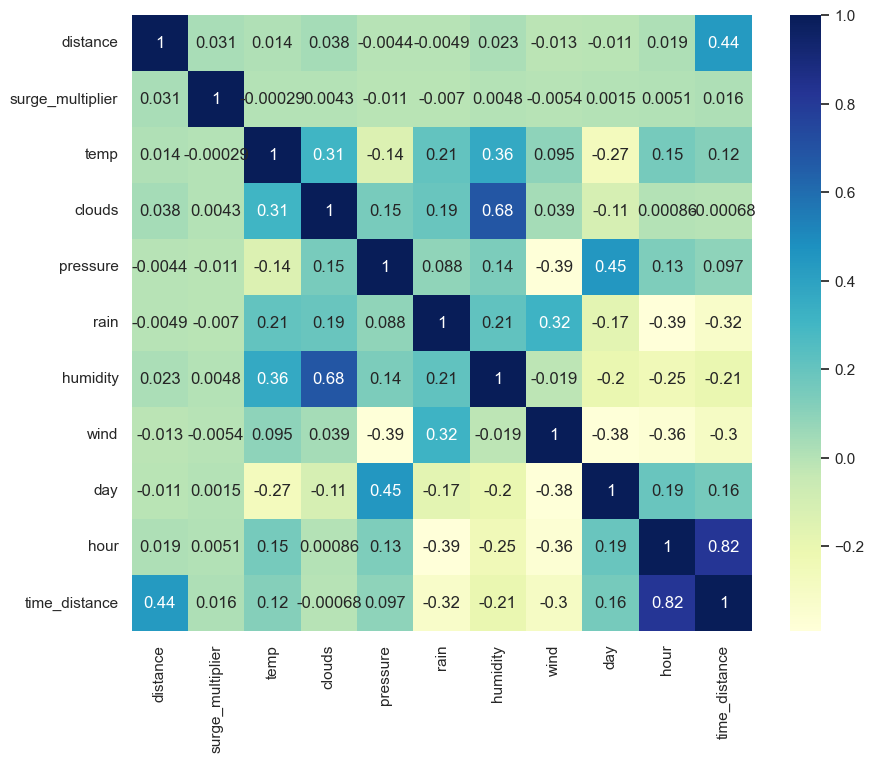

In [997]:
# Checking features for correlation

plt.figure(figsize = (10,8))
corre = train[conti_feat].corr()
sns.heatmap(corre,annot = True, cmap = 'YlGnBu')
plt.show

In [998]:
# check level of importance of features to target variable

from sklearn.feature_selection import mutual_info_regression

mu=mutual_info_regression(x_train,y_train)
imp = pd.DataFrame(mu,index=x_train.columns)

imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)

,Importance
distance,0.578299
cab_type_Uber,0.400350
time_distance,0.357941
name_Black SUV,0.193435
name_Shared,0.184972
name_Lux Black XL,0.182165
name_UberPool,0.138557
name_Lux Black,0.112613
name_UberXL,0.105952
name_Lyft,0.102998


In [999]:
x_train.drop('hour', axis=1, inplace=True)

In [1000]:
def preparetest(df):

    
    df.reset_index(drop=True, inplace=True)
    
        

    # Use the same encoders used for training data
    enc_data = pd.DataFrame(encoder.transform(np.array(df[['destination', 'source', 
                                                                            'name', 'cab_type']])).toarray(), 
                                                                            columns=encoder.get_feature_names_out(['destination', 'source', 'name', 'cab_type']))

    # Concatenate the encoded features
    df = pd.concat([df, enc_data], axis=1)

    # Drop the original categorical columns
    df.drop(['destination', 'source', 'name', 'cab_type'], axis=1, inplace=True)

    

   


    def timedist (df,dist_col,hour_col):
        new = []

        df['time_distance'] = df[dist_col] * df[hour_col]

        return df
    

    timedist (df, 'distance', 'hour')


    x_test = df.drop('price', axis =1)
    y_test = df['price']
   

    col = x_test.columns

    x_test = Scaler.transform(x_test)

    x_test = pd.DataFrame(x_test,columns=col)

    x_test.drop('hour', axis=1, inplace=True)

   
    return x_test, y_test
    


In [1001]:
x_test, y_test = preparetest(test)

In [1002]:
preparetest(test)

(       distance  surge_multiplier      temp    clouds  pressure      rain  humidity      wind       day  destination_Beacon Hill  destination_Boston University  destination_Fenway  destination_Financial District  destination_Haymarket Square  destination_North End  destination_North Station  destination_Northeastern University  destination_South Station  destination_Theatre District  destination_West End  source_Beacon Hill  source_Boston University  source_Fenway  source_Financial District  source_Haymarket Square  source_North End  source_North Station  source_Northeastern University  source_South Station  source_Theatre District  source_West End  name_Black SUV  name_Lux  name_Lux Black  name_Lux Black XL  name_Lyft  name_Lyft XL  name_Shared  name_UberPool  name_UberX  name_UberXL  name_WAV  cab_type_Uber  time_distance
 0      0.556797             0.125  0.571179  0.977778  0.516423  0.270340  0.847826  0.577173  0.166667                      0.0                            0.0   

In [1003]:
# function for different algorithms to be use

def model_to_use(input_ml_algo):
    if input_ml_algo == 'DT':
        algo = DecisionTreeRegressor()
    elif input_ml_algo == 'RF':
        algo = RandomForestRegressor()
    elif input_ml_algo == 'XGBR':
        algo = XGBRegressor()
    elif input_ml_algo == 'LGBMR':
        algo = LGBMRegressor()
    elif input_ml_algo=='LR':
        algo = LinearRegression()
    return algo

In [1004]:
def evaluate(model):
    y_train_pred = model.predict(x_train) 
    y_pred = model.predict(x_test) 

    
    print('Train_MAE: ', mean_absolute_error(y_train,y_train_pred))
    print('Test_MAE: ', mean_absolute_error(y_test,y_pred))

    
    # Calculate the IQR for the predicted values
    iqr_train_predicted = np.percentile(y_train_pred, 75) - np.percentile(y_train_pred, 25)
    iqr_test_predicted = np.percentile(y_pred, 75) - np.percentile(y_pred, 25)

    print("\n")
    print("Train Predicted Values IQR:", iqr_train_predicted)
    print("Test Predicted Values IQR:", iqr_test_predicted)


    # Calculate the Median Absolute Error (MedAE) for the training and test sets
    medae_train = median_absolute_error(y_train, y_train_pred)
    medae_test = median_absolute_error(y_test, y_pred)

    print("\n")
    print("Median Absolute Error (MedAE) for Training Set:", medae_train)
    print("Median Absolute Error (MedAE) for Test Set:", medae_test)

    print("\n")
    print('Train r2 score: ', r2_score(y_train,y_train_pred))
    print('Test r2 score: ', r2_score(y_test, y_pred))


In [1005]:
model1 = model_to_use('LR')
model1.fit(x_train,y_train)
evaluate(model1)

Train_MAE:  1.7000623261247125
Test_MAE:  1.7041851472872354


Train Predicted Values IQR: 12.77667236328125
Test Predicted Values IQR: 12.685012817382812


Median Absolute Error (MedAE) for Training Set: 1.3253173828125
Median Absolute Error (MedAE) for Test Set: 1.326690673828125


Train r2 score:  0.9321322148748766
Test r2 score:  0.9306008213794064


In [1006]:
model2 = model_to_use('DT')
model2.fit(x_train, y_train)
evaluate(model2)

Train_MAE:  0.32266658705643
Test_MAE:  1.0045766461178722


Train Predicted Values IQR: 13.5
Test Predicted Values IQR: 13.5


Median Absolute Error (MedAE) for Training Set: 0.0
Median Absolute Error (MedAE) for Test Set: 0.5


Train r2 score:  0.9921495411697852
Test r2 score:  0.9575747485794442


In [1007]:
model3 = model_to_use('RF')
model3.fit(x_train,y_train)
evaluate(model3)

Train_MAE:  0.5124810680160207
Test_MAE:  0.9772890434741534


Train Predicted Values IQR: 13.350494047619046
Test Predicted Values IQR: 13.271875000000001


Median Absolute Error (MedAE) for Training Set: 0.2699999999999996
Median Absolute Error (MedAE) for Test Set: 0.5949999999999998


Train r2 score:  0.9900834768952131
Test r2 score:  0.9693443982100237


In [1008]:
model4 = model_to_use('XGBR')
model4.fit(x_train, y_train)
evaluate(model4)

Train_MAE:  1.0061663493862403
Test_MAE:  1.051194935972128


Train Predicted Values IQR: 13.076990604400635
Test Predicted Values IQR: 13.01118779182434


Median Absolute Error (MedAE) for Training Set: 0.7374587059020996
Median Absolute Error (MedAE) for Test Set: 0.7600367069244385


Train r2 score:  0.9742287521374868
Test r2 score:  0.9703734145586002


In [1009]:
model5 = model_to_use('LGBMR')
model5.fit(x_train, y_train)
evaluate(model5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 150535, number of used features: 44
[LightGBM] [Info] Start training from score 16.405111
Train_MAE:  1.0904875373140808
Test_MAE:  1.0996834039935748


Train Predicted Values IQR: 13.050281431931229
Test Predicted Values IQR: 13.001811279983029


Median Absolute Error (MedAE) for Training Set: 0.7885832964357373
Median Absolute Error (MedAE) for Test Set: 0.7894183742831946


Train r2 score:  0.9692178325274914
Test r2 score:  0.9679873512411371


In [1010]:
from pickle import dump

dump(model5, open('lr_model.pkl', 'wb'))

dump(encoder, open('lr_enc.pkl', 'wb'))

dump(Scaler, open('lr_scaler.pkl', 'wb'))

In [1011]:
x_train.columns

Index(['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day', 'destination_Beacon Hill', 'destination_Boston University', 'destination_Fenway', 'destination_Financial District', 'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 'destination_Northeastern University', 'destination_South Station', 'destination_Theatre District', 'destination_West End', 'source_Beacon Hill', 'source_Boston University', 'source_Fenway', 'source_Financial District', 'source_Haymarket Square', 'source_North End', 'source_North Station', 'source_Northeastern University', 'source_South Station', 'source_Theatre District', 'source_West End', 'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_UberPool', 'name_UberX', 'name_UberXL', 'name_WAV', 'cab_type_Uber', 'time_distance'], dtype='object')

In [1012]:
cat =['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day', 'cab_type_Uber', 'destination_Beacon Hill', 'destination_Boston University', 'destination_Fenway', 'destination_Financial District', 'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 'destination_Northeastern University', 'destination_South Station', 'destination_Theatre District', 'destination_West End', 'source_Beacon Hill', 'source_Boston University', 'source_Fenway', 'source_Financial District', 'source_Haymarket Square', 'source_North End', 'source_North Station', 'source_Northeastern University', 'source_South Station', 'source_Theatre District', 'source_West End', 'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_UberPool', 'name_UberX', 'name_UberXL', 'name_WAV', 'time_distance']

In [1013]:
len(cat)

44

In [1014]:
final_dataframe.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,temp,clouds,pressure,rain,humidity,wind,day,hour
0,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,44.31,1.00,1003.17,0.1123,0.90,13.69,1,2
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,43.82,0.99,1002.59,0.0997,0.89,11.57,1,2
2,1.08,Lyft,Northeastern University,Back Bay,27.5,1.0,Lux Black XL,44.56,0.99,990.78,0.0213,0.96,5.87,1,10
3,1.08,Lyft,Northeastern University,Back Bay,27.5,1.0,Lux Black XL,44.95,0.99,990.87,0.0087,0.97,6.14,1,10
4,1.11,Uber,West End,North End,7.5,1.0,WAV,42.36,1.00,1012.15,0.2088,0.77,11.46,6,23


In [1015]:
final_dataframe['hour'].unique()

array([ 2, 10, 23, 16,  3, 18,  9,  8, 14,  1,  7, 21, 22, 12, 17, 13,  5,
        4,  0, 20, 11,  6, 15, 19], dtype=int64)

In [1016]:
final_dataframe.columns

Index(['distance', 'cab_type', 'destination', 'source', 'price', 'surge_multiplier', 'name', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'day', 'hour'], dtype='object')

In [1017]:
!streamlit run pricepredict.py

^C
